# Nitrogen Dioxide - AURA OMI

## Overview

- **Main ideas:**
    - Intensive operations that use a lot of RAM memory in the first run when we do not have a file for preprocessed data. After that, the operations are easier and do not require much RAM. Run this notebook in `aerossol` server.
    - Global data `(0.25x0.25º)` at `daily` time step from 2004-10-01 until now.
    - Use data for `Southeastern Brazil` only.
    - Explore single `HDF5` data file for NO2 in the tropospheric column.
    - Differences with and without mask for clouds.
    - Convert all data files from `HDF5` to `netcdf` if this was not done before.
    - Compare periods of different isolation rates for different years.

## Initial setup

In [1]:
%%time

# Load packages.
import sys
import os
import h5py
import glob
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns

from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

CPU times: user 1.6 s, sys: 120 ms, total: 1.72 s
Wall time: 1.74 s


In [2]:
%%time

print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0

>>> Computer:
* Hostname: aerossol
* User: sandroal
* Directory: /LFASGI/sandroal/notebooks
* Date: Sun Nov 22 21:05:24 GMT 2020
* CPUs: 24
CPU times: user 20 ms, sys: 32 ms, total: 52 ms
Wall time: 621 ms


In [3]:
# Main directory.
DATA_FOLDER = "/LFASGI/sandroal/data_sets/OMI/NO2/L3_daily_025/"

# Where figures will be put.
FIG_PATH = "/LFASGI/sandroal/images/covid19/"

# Final results.
save_fig = True

# Map borders for Southeastern Brazil region.
loni, lonf, lati, latf = -55, -40, -30, -15

In [4]:
%%time

# My repository.
repository = "/LFASGI/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
import cdlearn

CPU times: user 1.31 s, sys: 128 ms, total: 1.44 s
Wall time: 1.5 s


In [5]:
%%time

# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 30.8 ms


In [6]:
# All hdf5 data files.
FILES = sorted(glob.glob(DATA_FOLDER + "/*.he5"))

print(">>>", len(FILES), "data files inside", DATA_FOLDER + ":")

for FILE in FILES[:5]:
    print("*", os.path.basename(FILE))
print("...")
for FILE in FILES[-5:]:
    print("*", os.path.basename(FILE))

>>> 5741 data files inside /LFASGI/sandroal/data_sets/OMI/NO2/L3_daily_025/:
* OMI-Aura_L3-OMNO2d_2004m1001_v003-2019m1121t082956.he5
* OMI-Aura_L3-OMNO2d_2004m1002_v003-2019m1120t150658.he5
* OMI-Aura_L3-OMNO2d_2004m1003_v003-2019m1121t083143.he5
* OMI-Aura_L3-OMNO2d_2004m1004_v003-2019m1120t150808.he5
* OMI-Aura_L3-OMNO2d_2004m1005_v003-2019m1121t083127.he5
...
* OMI-Aura_L3-OMNO2d_2020m0722_v003-2020m0723t180208.he5
* OMI-Aura_L3-OMNO2d_2020m0723_v003-2020m0725t093323.he5
* OMI-Aura_L3-OMNO2d_2020m0724_v003-2020m0725t172005.he5
* OMI-Aura_L3-OMNO2d_2020m0725_v003-2020m0726t181310.he5
* OMI-Aura_L3-OMNO2d_2020m0726_v003-2020m0727t234924.he5


## Explore single h5 data file

In [7]:
# Display contents of a file.
!h5dump --contents {FILES[-1]}

HDF5 "/LFASGI/sandroal/data_sets/OMI/NO2/L3_daily_025/OMI-Aura_L3-OMNO2d_2020m0726_v003-2020m0727t234924.he5" {
FILE_CONTENTS {
 group      /
 group      /HDFEOS
 group      /HDFEOS/ADDITIONAL
 group      /HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
 group      /HDFEOS/GRIDS
 group      /HDFEOS/GRIDS/ColumnAmountNO2
 group      /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields
 dataset    /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2
 dataset    /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2CloudScreened
 dataset    /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2Trop
 dataset    /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2TropCloudScreened
 dataset    /HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/Weight
 group      /HDFEOS INFORMATION
 dataset    /HDFEOS INFORMATION/StructMetadata.0
 }
}


## hdf2netcd function

In [8]:
# Auxiliary function.
def make_xarray_dataset(
    HDF5_DATA_FILE,
    DATASETS=["/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2Trop", 
              "/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2TropCloudScreened"],
    ATTRIBUTES="/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES"
    ):

    # Create a new file object.
    f = h5py.File(name=HDF5_DATA_FILE, mode="r")

    # Attributes.
    AT = f[ATTRIBUTES]

    # HDF5 dataset objects.
    NO2TropDS = f[DATASETS[0]]
    NO2TropCloudScreenedDS = f[DATASETS[1]]
    
    # Extract data as a numpy arrays.
    NO2TropData = NO2TropDS[:]
    NO2TropCloudScreenedData = NO2TropCloudScreenedDS[:] 
    
    # Fill nan values.
    mask1 = NO2TropData == NO2TropDS.attrs["MissingValue"][0]
    NO2TropData[mask1] = np.nan
    mask2 = NO2TropCloudScreenedData == NO2TropCloudScreenedDS.attrs["MissingValue"][0]    
    NO2TropCloudScreenedData[mask2] = np.nan

    # Only positive concentrations.
    NO2TropData[NO2TropData < 0] = 0
    NO2TropCloudScreenedData[NO2TropCloudScreenedData < 0] = 0
    
    # Latitude and longitude grid points.
    LAT = np.arange(-90, 90, 0.25)
    LON = np.arange(-180, 180, 0.25)

    # Point in time.
    TIME_POINT = np.datetime64(
        AT.attrs["GranuleYear"].astype(str)[0] + "-" + \
        AT.attrs["GranuleMonth"].astype(str)[0].zfill(2) + "-" + \
        AT.attrs["GranuleDay"].astype(str)[0].zfill(2)
    )

    # Put data as xarray DataSet object.
    DataSet = xr.Dataset(
        data_vars={"NO2": (("lat", "lon"), NO2TropData),
                   "NO2CS": (("lat", "lon"), NO2TropCloudScreenedData)},
        coords={"lat": LAT, "lon": LON}
    )

    # Time as attribute.
    DataSet["time"] = TIME_POINT

    return DataSet

## Global cloud mask for a single file

In [9]:
%%time

# Random data file.
DS = make_xarray_dataset(HDF5_DATA_FILE=np.random.choice(FILES))
print(DS)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    NO2      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    NO2CS    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    time     datetime64[ns] 2008-06-12
CPU times: user 40 ms, sys: 36 ms, total: 76 ms
Wall time: 324 ms


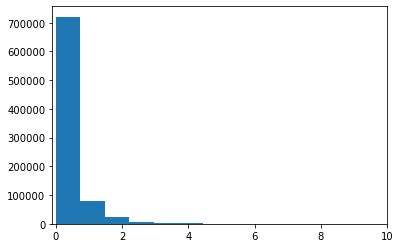

In [10]:
# Range of valid data.
scale = 1e15
plt.hist(DS.NO2.values.flatten() / scale, bins=100)
plt.xlim((-0.1, 10));

CPU times: user 4.36 s, sys: 232 ms, total: 4.59 s
Wall time: 5.51 s


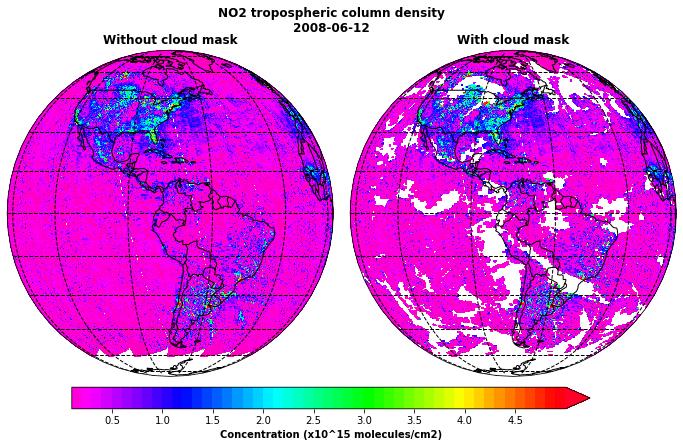

In [11]:
%%time

# Overall figure.
fig = plt.figure(figsize=(12, 6))

# Two global maps.
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-75, 0))
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(-75, 0))

# Common properties.
for axis in [ax1, ax2]:
    axis.set_global()
    axis.coastlines()
    axis.add_feature(cfeature.BORDERS)  

# Meridians and parallels. 
gl1 = ax1.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=False,
    xlocs=np.arange(-180, 180, 30),
    ylocs=np.arange(-90, 90, 15),
    linewidth=1, 
    color="black", 
    linestyle="--"
)

# Meridians and parallels. 
gl2 = ax2.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=False,
    xlocs=np.arange(-180, 180, 30),
    ylocs=np.arange(-90, 90, 15),
    linewidth=1, 
    color="black", 
    linestyle="--"
)

# Data into first map.
plotmap1 = (DS.NO2 / scale).plot(
    ax=ax1, 
    transform=ccrs.PlateCarree(), 
    vmin=0.1, 
    vmax=5,
    levels=np.arange(0.1, 5 + 0.1, 0.1),
    cmap=plt.cm.gist_rainbow_r,
    add_colorbar=False,
)

# Data into second map.
plotmap2 = (DS.NO2CS / scale).plot(
    ax=ax2, 
    transform=ccrs.PlateCarree(), 
    vmin=0.1, 
    vmax=5,
    levels=np.arange(0, 5 + 0.1, 0.1),
    cmap=plt.cm.gist_rainbow_r,
    add_colorbar=False,
)

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.20, 0.05, 0.60, 0.05])
cb = fig.colorbar(
    mappable=plotmap1, 
    cax=cbar_ax,
    extend="max",
    orientation="horizontal"
)
cb.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")
cb.set_ticks(np.arange(0.5, 5, 0.5))

# Adjustments.
ax1.set_title("Without cloud mask", weight="bold")
ax2.set_title("With cloud mask", weight="bold")
plt.subplots_adjust(wspace=0.05)
fig.suptitle(
    "NO2 tropospheric column density\n" + DS.time.values.astype(str)[:10], 
    weight="bold"
)

# Save figures.
plt.savefig(
    FIG_PATH + "no2cs_omi.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

## Make netcdf files

In [12]:
%%time

# Loop over all files.
for FILE_PATH in FILES:
    
    # File path without extension.
    FILE_PATH_WE = os.path.splitext(FILE_PATH)[0]
    
    # Netcdf file path.
    FILE_PATH_NETCDF = FILE_PATH_WE + ".nc"
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(FILE_PATH_NETCDF): 

        # xarray DataSet object.
        DS = make_xarray_dataset(HDF5_DATA_FILE=FILE_PATH)
        
        # Export data as netcdf.
        DS.to_netcdf(path=FILE_PATH_NETCDF)

CPU times: user 52 ms, sys: 108 ms, total: 160 ms
Wall time: 644 ms


In [13]:
# All netcdf data files.
FILES_PATHS = sorted(glob.glob(DATA_FOLDER + "/*.nc"))

print(">>>", len(FILES_PATHS), "data files inside", DATA_FOLDER + ":")

for FILE_PATH in FILES_PATHS[:5]:
    print("*", os.path.basename(FILE_PATH))
print("...")
for FILE_PATH in FILES_PATHS[-5:]:
    print("*", os.path.basename(FILE_PATH))

>>> 5741 data files inside /LFASGI/sandroal/data_sets/OMI/NO2/L3_daily_025/:
* OMI-Aura_L3-OMNO2d_2004m1001_v003-2019m1121t082956.nc
* OMI-Aura_L3-OMNO2d_2004m1002_v003-2019m1120t150658.nc
* OMI-Aura_L3-OMNO2d_2004m1003_v003-2019m1121t083143.nc
* OMI-Aura_L3-OMNO2d_2004m1004_v003-2019m1120t150808.nc
* OMI-Aura_L3-OMNO2d_2004m1005_v003-2019m1121t083127.nc
...
* OMI-Aura_L3-OMNO2d_2020m0722_v003-2020m0723t180208.nc
* OMI-Aura_L3-OMNO2d_2020m0723_v003-2020m0725t093323.nc
* OMI-Aura_L3-OMNO2d_2020m0724_v003-2020m0725t172005.nc
* OMI-Aura_L3-OMNO2d_2020m0725_v003-2020m0726t181310.nc
* OMI-Aura_L3-OMNO2d_2020m0726_v003-2020m0727t234924.nc


## Load data for Southeastern Brazil

In [14]:
# Preprocessed file path.
ppdata_fp = "/LFASGI/sandroal/data_sets/OMI/NO2/" + \
            "ppdata_L3_daily_025_southeastern_brazil.nc"

In [15]:
%%time

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Lazy read.
    DS = xr.open_mfdataset(
        paths=FILES_PATHS[:-1], # Last data file with wrong time stamp!
        concat_dim="time",
        combine="nested",
        chunks={}
    )

    # Change order of dimensions.
    DS = DS.transpose("time", "lat", "lon")

    # Southeastern Brazil.
    DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

    # Load into memory!
    with ProgressBar():
        DS = DS.load()

    # Export preprocessed data.
    DS.to_netcdf(path=ppdata_fp, mode="w")    
        
else:
    DS = xr.open_dataset(ppdata_fp)    
        
# Show it.
print(); print(DS)


<xarray.Dataset>
Dimensions:  (lat: 61, lon: 61, time: 5740)
Coordinates:
  * lon      (lon) float64 -55.0 -54.75 -54.5 -54.25 ... -40.5 -40.25 -40.0
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -15.5 -15.25 -15.0
  * time     (time) datetime64[ns] 2004-10-01 2004-10-02 ... 2020-07-25
Data variables:
    NO2      (time, lat, lon) float32 ...
    NO2CS    (time, lat, lon) float32 ...
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 18.2 ms


In [16]:
# For interpolation. Gain factor along latitude and longitude.
# This means squares smaller by a gain**2 factor.
gain = 4
        
# Interpolated grid.
lat1 = DS.lat[0].values
lat2 = DS.lat[-1].values
lon1 = DS.lon[0].values
lon2 = DS.lon[-1].values
dlat = np.diff(DS.lat[:2].values) / gain
dlon = np.diff(DS.lon[:2].values) / gain
grid={
    "lat": np.arange(lat1, lat2 + dlat, dlat), 
    "lon": np.arange(lon1, lon2 + dlon, dlon)
}

## São Paulo State Shapefiles

In [17]:
# Whole São Paulo State.
shp_file = "/LFASGI/sandroal/data_sets/MUNICIPALITIES/SP/sao_paulo.shp"

# Load data.
gdf = gpd.read_file(shp_file)

# Show it.
print(">>> Columns:\n", gdf.columns)

>>> Columns:
 Index(['CODMUNIC', 'NOMEMUNICP', 'NOMEMUNIC', 'CODUF', 'NOMEUF_1', 'NOMEUF_2',
       'REGIAO_1', 'REGIAO_2', 'CODMESO', 'NOMEMESO', 'CODMICRO', 'NOMEMICRO',
       'CODUFMESO', 'CODUFMESOM', 'AREA_97', 'ID', 'geometry'],
      dtype='object')


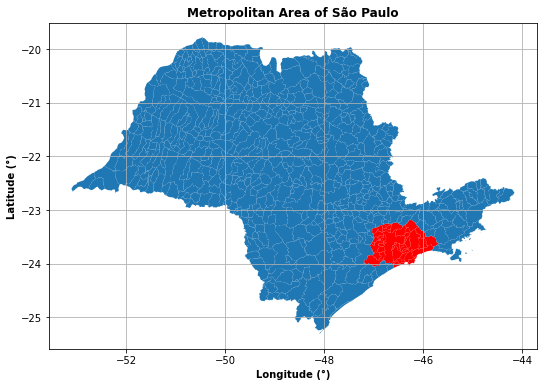

In [18]:
# Metropolitan area of São Paulo. 
masp = gdf.NOMEMESO == "METROPOLITANA DE SAO PAULO"
ax = gdf[masp].plot(facecolor="red", figsize=(12, 6))
gdf[~masp].plot(ax=ax)
plt.title("Metropolitan Area of São Paulo", weight="bold")
plt.grid()
plt.xlabel("Longitude (°)", weight="bold")
_ = plt.ylabel("Latitude (°)", weight="bold")

## Mean for whole time range

In [19]:
# Box around São Paulo Metropolitan Region.
box_lat_i = -24.2; box_lat_f = -23.0; box_lon_i = -47.5; box_lon_f = -45.5 
box_dlat = box_lat_f - box_lat_i
box_dlon = box_lon_f - box_lon_i
box_lat_slice = slice(box_lat_i, box_lat_f)
box_lon_slice = slice(box_lon_i, box_lon_f)

CPU times: user 1.51 s, sys: 128 ms, total: 1.64 s
Wall time: 2.07 s


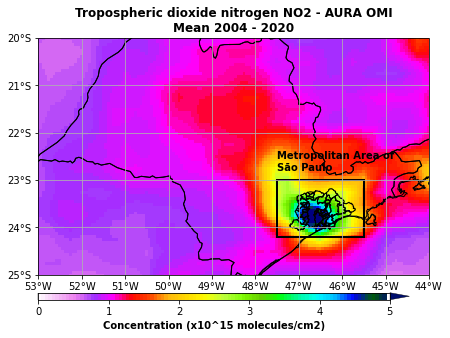

In [20]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-53, -44, -25, -20], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-53, -44 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -20 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-53, -44 + 1, 1), ylocs=range(-25, -20 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )
    
# Mean for all time range available.
p = (DS.NO2.mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=0.00,
    vmax=5.00,
    levels=np.arange(0.00, 5.00 + 0.05, 0.05),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")        

# Box around São Paulo city.
axgr[0].text(x=box_lon_i, y=-22.8, s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
    xy=[box_lon_i, box_lat_i], 
    width=box_dlon, 
    height=box_dlat,
    fill=None,
    lw=2,
    edgecolor="black",
    facecolor="black"
))
      
# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1)
    
# Adjustments.
axgr[0].set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI\nMean 2004 - 2020", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_time_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Time series for whole time range

CPU times: user 784 ms, sys: 52 ms, total: 836 ms
Wall time: 1.83 s


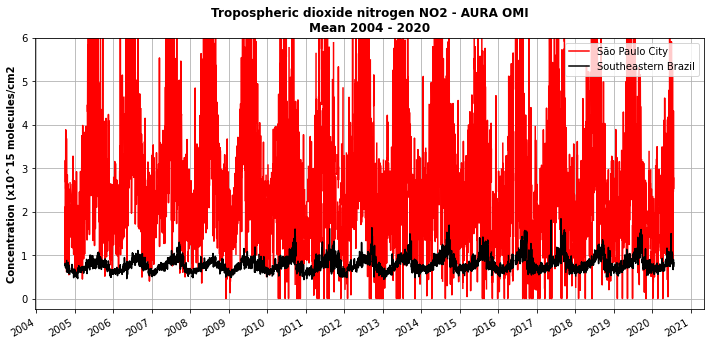

In [21]:
%%time

# Make figure and axis.
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

# São Paulo City
(DS.NO2.sel(lat=box_lat_slice, lon=box_lon_slice).mean(dim=["lat", "lon"]) / scale).\
       plot(ax=axis, color="red", label="São Paulo City")

# Southeastern Brazil.
(DS.NO2.mean(dim=["lat", "lon"]) / scale).\
        plot(ax=axis, color="black", label="Southeastern Brazil")

# Adjustments.
axis.set_ylim((-0.25, 6))
axis.set_ylabel("Concentration (x10^15 molecules/cm2", weight="bold")
axis.set_xlabel(None)
axis.xaxis.set_major_locator(mdates.YearLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axis.grid()
axis.legend()
axis.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI\nMean 2004 - 2020", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_time_series_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 340 ms, sys: 128 ms, total: 468 ms
Wall time: 467 ms


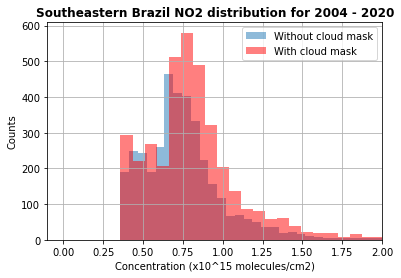

In [22]:
%%time

# Mean distribution.
plt.hist(
    x=DS.NO2.mean("time").values.flatten()/scale, 
    bins=100, 
    alpha=0.5,
    label="Without cloud mask"
)
plt.hist(
    x=DS.NO2CS.mean("time").values.flatten()/scale, 
    bins=100, 
    alpha=0.5, 
    color="red",
    label="With cloud mask"
)
plt.xlim((-0.1, 2.0))
plt.grid(); plt.legend()
plt.title("Southeastern Brazil NO2 distribution for 2004 - 2020", weight="bold")
plt.ylabel("Counts"); _ = plt.xlabel("Concentration (x10^15 molecules/cm2)")

CPU times: user 220 ms, sys: 80 ms, total: 300 ms
Wall time: 301 ms


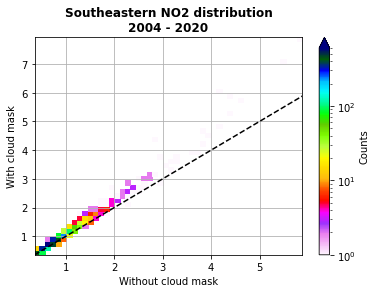

In [23]:
%%time

# Bi-histogram.
_, _, _, image = plt.hist2d(
    x=DS.NO2.mean("time").values.flatten() / scale,
    y=DS.NO2CS.mean("time").values.flatten() / scale,
    bins=50,
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm()
)

# Diagonal line.
p = plt.gca().get_xlim()
plt.plot(p, p, "--k", label="diagonal")

# Color bar.
cb = plt.colorbar(
    orientation="vertical",
    mappable=image,  
    extend="max"
)
cb.set_label("Counts")

# Adjustments.
plt.grid()
plt.title("Southeastern NO2 distribution\n2004 - 2020", weight="bold")
plt.xlabel("Without cloud mask"); _ = plt.ylabel("With cloud mask")

## Define parameters for periods

In [24]:
%%time

# For selecting data. Keys are years and values are slices of date strings.
p0s = {}; p1s = {}; p2s = {}
p3s = {}; p4s = {}; p5s = {}; p6s = {}

# For titles in figures. Keys are years and values are strings.
t0s = {}; t1s = {}; t2s = {}
t3s = {}; t4s = {}; t5s = {}; t6s = {}

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    
    # Same period for each year.
    p0s[year] = slice(str(year) + "-" + "02-12", str(year) + "-" + "03-13")
    t0s[year] = str(year) + "\nPeriod 0: February 12 - March 13"
    
    p1s[year] = slice(str(year) + "-" + "03-14", str(year) + "-" + "03-23")
    t1s[year] = str(year) + "\nPeriod 1: March 14 - March 23"

    p2s[year] = slice(str(year) + "-" + "03-24", str(year) + "-" + "04-03")
    t2s[year] = str(year) + "\nPeriod 2: March 24 - April 03"

    p3s[year] = slice(str(year) + "-" + "04-04", str(year) + "-" + "05-04")
    t3s[year] = str(year) + "\nPeriod 3: April 04 - May 04"

    p4s[year] = slice(str(year) + "-" + "05-05", str(year) + "-" + "06-05")
    t4s[year] = str(year) + "\nPeriod 4: May 05 - June 05"

    p5s[year] = slice(str(year) + "-" + "06-06", str(year) + "-" + "07-05")
    t5s[year] = str(year) + "\nPeriod 5: June 06 - July 05"

    p6s[year] = slice(str(year) + "-" + "07-06", str(year) + "-" + "08-05")
    t6s[year] = str(year) + "\nPeriod 6: July 06 - August 05"

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.84 ms


In [25]:
# Parameters for plots.
vmin = 0.0; vmax = 6.0; dv = 1.0 # Absolute concentrations.  
dvmin = -3.0; dvmax = 3.0; ddv = 1.0 # Variations.  

## Period 0: 12/02 - 13/03

CPU times: user 5.9 s, sys: 96 ms, total: 6 s
Wall time: 6.52 s


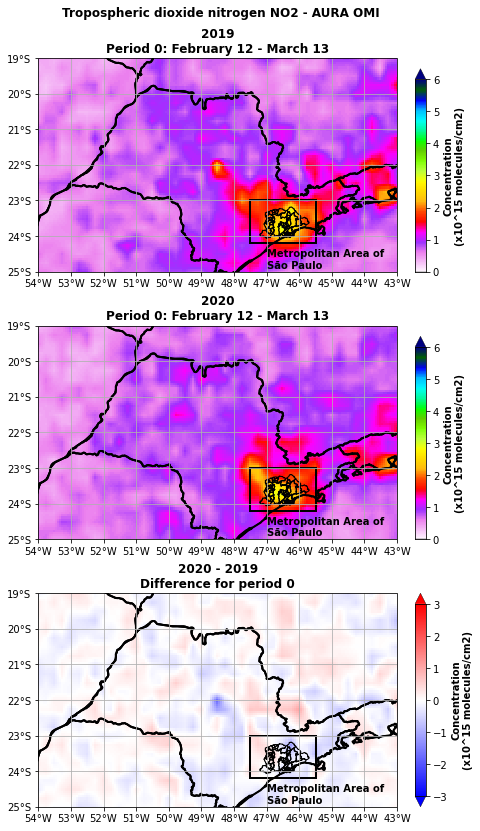

In [26]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p0s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p0s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p0s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p0s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t0s[2019], weight="bold")
axgr[1].set_title(t0s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 0", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p0_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 1: 14/03 - 23/03

CPU times: user 4.63 s, sys: 84 ms, total: 4.72 s
Wall time: 5.24 s


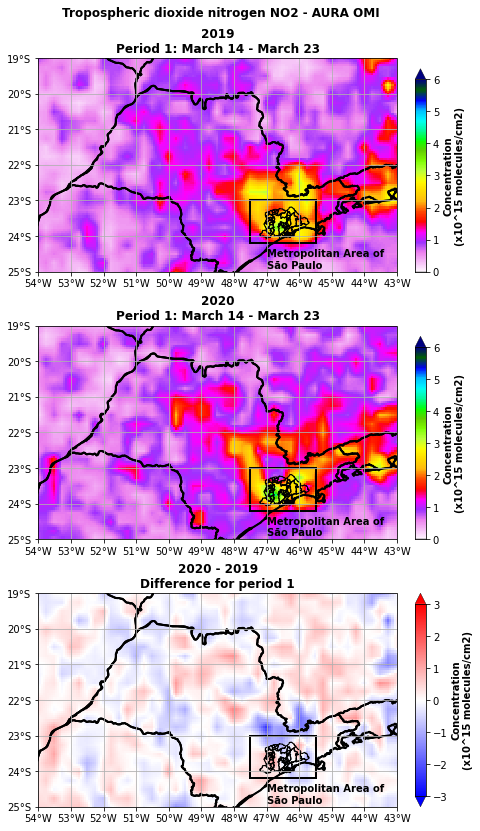

In [27]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p1s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p1s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p1s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p1s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t1s[2019], weight="bold")
axgr[1].set_title(t1s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 1", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p1_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 2: 24/03 - 03/04

CPU times: user 4.66 s, sys: 76 ms, total: 4.73 s
Wall time: 4.91 s


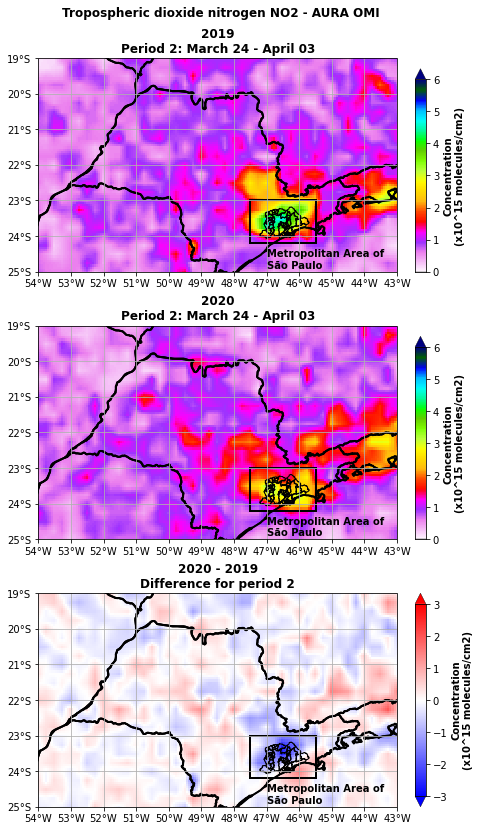

In [28]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p2s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p2s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p2s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p2s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t2s[2019], weight="bold")
axgr[1].set_title(t2s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 2", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p2_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 3: 04/04 - 04/05

CPU times: user 4.84 s, sys: 44 ms, total: 4.88 s
Wall time: 5.04 s


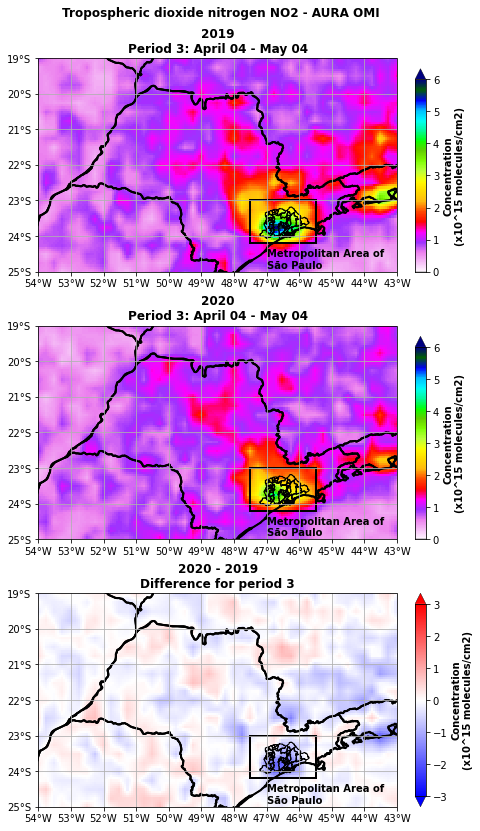

In [29]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p3s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p3s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p3s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p3s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t3s[2019], weight="bold")
axgr[1].set_title(t3s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 3", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p3_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 4: 05/05 - 05/06

CPU times: user 4.66 s, sys: 56 ms, total: 4.72 s
Wall time: 5.31 s


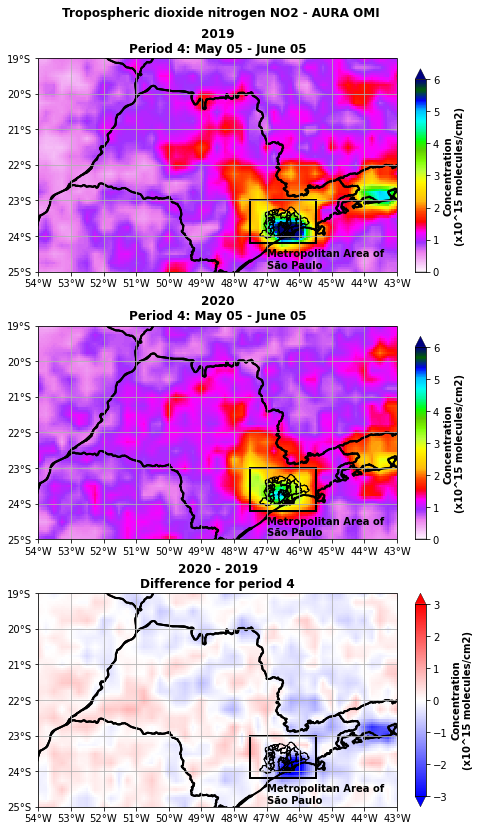

In [30]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p4s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p4s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p4s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p4s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t4s[2019], weight="bold")
axgr[1].set_title(t4s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 4", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p4_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 5: 06/06 - 05/07

CPU times: user 4.7 s, sys: 36 ms, total: 4.73 s
Wall time: 5.19 s


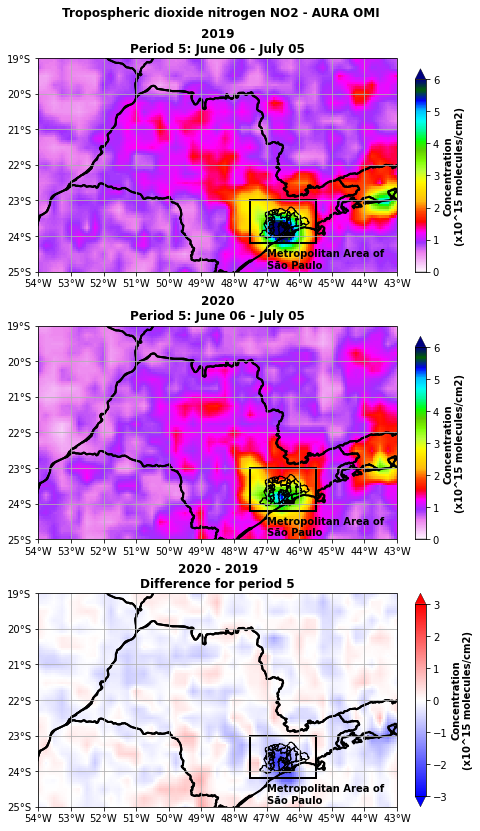

In [31]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p5s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p5s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p5s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p5s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t5s[2019], weight="bold")
axgr[1].set_title(t5s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 5", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p5_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 6: 06/07- 05/08

CPU times: user 4.67 s, sys: 56 ms, total: 4.72 s
Wall time: 5.33 s


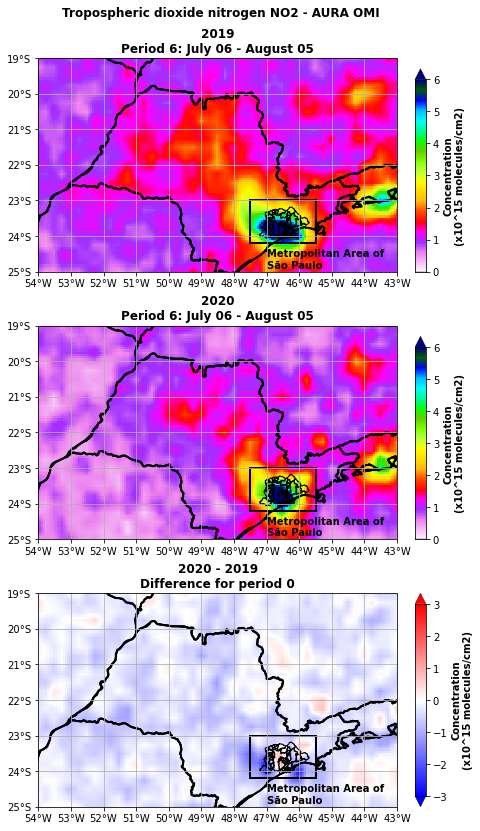

In [32]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 13))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 1),
    axes_pad=0.75,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-54, -43, -25, -19], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.add_feature(cfeature.STATES, lw=2)
    axis.set_xticks(np.arange(-54, -43 + 1, 1), crs=projection)
    axis.set_yticks(np.arange(-25, -19 + 1, 1), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-54, -43 + 1, 1), ylocs=range(-25, -19 + 1, 1))   
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-47, y=-24.9, 
              s="Metropolitan Area of\nSão Paulo", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=2,
        edgecolor="black",
        facecolor="black"
    ))
    
# Period for 2019.
p = (DS.NO2.sel(time=p6s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold")

# Period for 2020.
p = (DS.NO2.sel(time=p6s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.NO2.sel(time=p6s[2020]).mean("time") / scale - \
     DS.NO2.sel(time=p6s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration\n(x10^15 molecules/cm2)", weight="bold") 

# Metropolitan area of São Paulo. 
gdf[masp].plot(ax=axgr[0], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[1], facecolor="none", edgecolor="black", lw=1) 
gdf[masp].plot(ax=axgr[2], facecolor="none", edgecolor="black", lw=1) 

# Adjustments.
fig.suptitle("Tropospheric dioxide nitrogen NO2 - AURA OMI", weight="bold")
plt.subplots_adjust(top=0.925)
axgr[0].set_title(t6s[2019], weight="bold")
axgr[1].set_title(t6s[2020], weight="bold")
axgr[2].set_title("2020 - 2019\nDifference for period 0", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_p6_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Heatmaps

In [33]:
%%time

# Means as a pandas DataFrame object.
df_mean = pd.DataFrame()
df_mean_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get mean data for Southeastern Brazil.
        mean = (DS.NO2.sel(time=period[year]).mean() / scale).values.flatten()
        df_mean.loc[index, str(year)] = mean
        
        # Get mean data of São Paulo City.
        mean_sp = (DS.NO2.sel(time=period[year]).\
                          sel(lat=box_lat_slice, lon=box_lon_slice).\
                          mean() / scale).values.flatten()
        df_mean_sp.loc[index, str(year)] = mean_sp

CPU times: user 744 ms, sys: 8 ms, total: 752 ms
Wall time: 754 ms


In [34]:
%%time

# Standard deviations as a pandas DataFrame object.
df_std = pd.DataFrame()
df_std_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get std data for Southeastern Brazil.
        std = (DS.NO2.sel(time=period[year]).std() / scale).values.flatten()
        df_std.loc[index, str(year)] = std
        
        # Get std data of São Paulo City.
        std_sp = (DS.NO2.sel(time=period[year]).\
                         sel(lat=box_lat_slice, lon=box_lon_slice).\
                         std() / scale).values.flatten()
        df_std_sp.loc[index, str(year)] = std_sp

CPU times: user 732 ms, sys: 0 ns, total: 732 ms
Wall time: 733 ms


In [35]:
%%time

# Medians as a pandas DataFrame object.
df_median = pd.DataFrame()
df_median_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get median data for Southeastern Brazil.
        median = (DS.NO2.sel(time=period[year]).median() / scale).values.flatten()
        df_median.loc[index, str(year)] = median
        
        # Get median data of São Paulo City.
        median_sp = (DS.NO2.sel(time=period[year]).\
                            sel(lat=box_lat_slice, lon=box_lon_slice).\
                            median() / scale).values.flatten()
        df_median_sp.loc[index, str(year)] = median_sp

CPU times: user 780 ms, sys: 0 ns, total: 780 ms
Wall time: 781 ms


CPU times: user 1.23 s, sys: 72 ms, total: 1.3 s
Wall time: 1.63 s


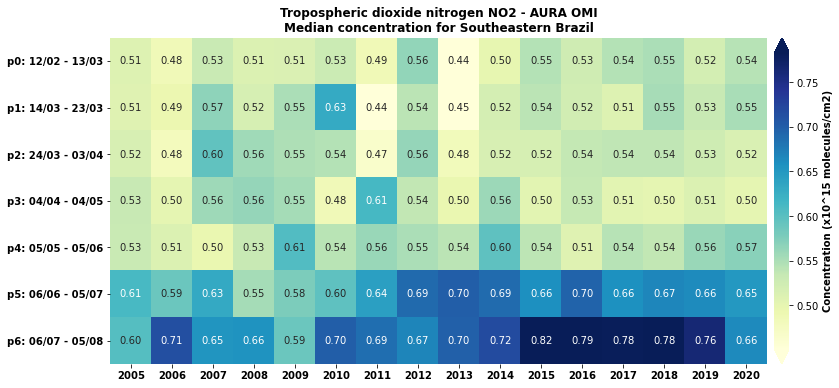

In [36]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_median,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nMedian concentration for Southeastern Brazil", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_median.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.39 s, sys: 100 ms, total: 1.49 s
Wall time: 1.52 s


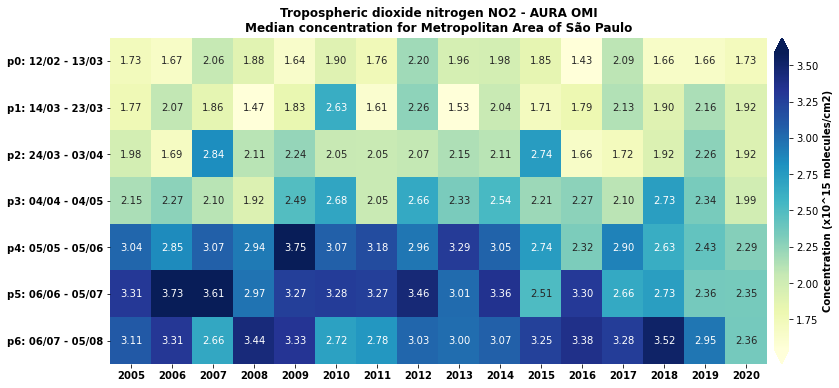

In [37]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_median_sp,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nMedian concentration for Metropolitan Area of São Paulo", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_sp_city_median.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.24 s, sys: 76 ms, total: 1.31 s
Wall time: 1.9 s


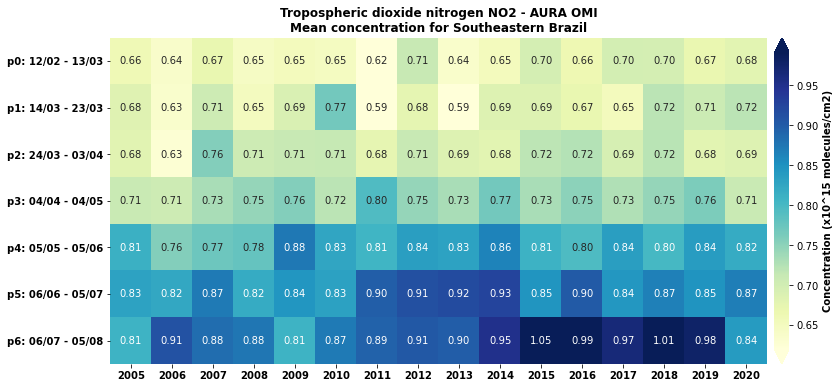

In [38]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_mean,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nMean concentration for Southeastern Brazil", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.2 s, sys: 96 ms, total: 1.29 s
Wall time: 1.34 s


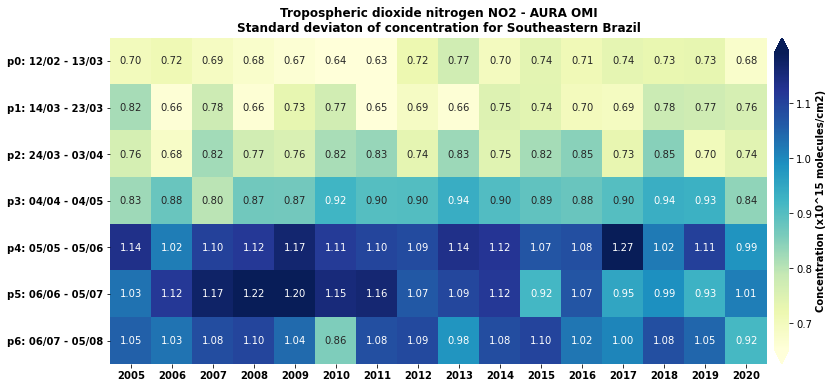

In [39]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_std,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nStandard deviaton of concentration for Southeastern Brazil", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_std.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.26 s, sys: 44 ms, total: 1.3 s
Wall time: 1.87 s


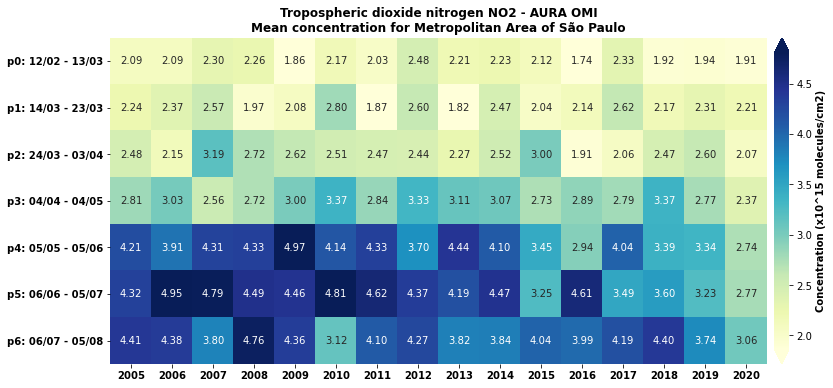

In [40]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_mean_sp,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nMean concentration for Metropolitan Area of São Paulo", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_sp_city_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.26 s, sys: 68 ms, total: 1.32 s
Wall time: 1.48 s


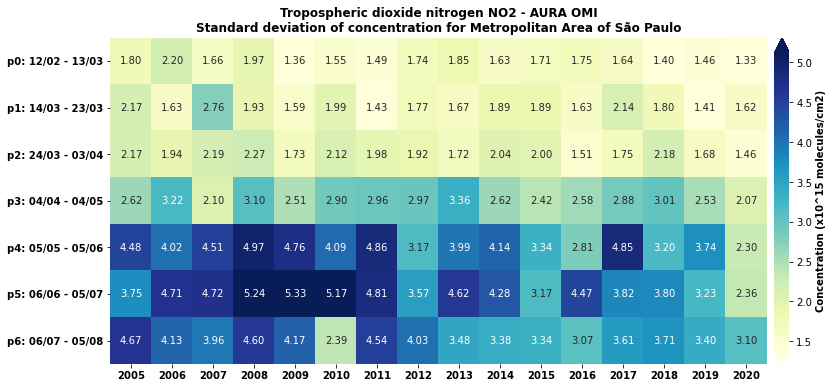

In [41]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_std_sp,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_title("Tropospheric dioxide nitrogen NO2 - AURA OMI" + \
             "\nStandard deviation of concentration for Metropolitan Area of São Paulo", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "no2_heatmap_sp_city_std.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )